In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# approx value prediction

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gridworld import standard_grid, negative_grid
from iterative_policy_evaluation_probabilistic import print_values, print_policy
from sklearn.kernel_approximation import Nystroem, RBFSampler

In [7]:
GAMMA = 0.9
ALPHA = 0.01
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [8]:
def epsilon_greedy(greedy, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return greedy[s]
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [9]:
def gather_samples(grid, n_episodes=10000):
  samples = []
  for _ in range(n_episodes):
    s = grid.reset()
    samples.append(s)
    while not grid.game_over():
      a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      r = grid.move(a)
      s = grid.current_state()
      samples.append(s)
  return samples

In [10]:
class Model:
  def __init__(self, grid):
    # fit the featurizer to data
    samples = gather_samples(grid)
    # self.featurizer = Nystroem()
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s):
    # sklearn expects num_features x num_examples, but s is only 1-D
    x = self.featurizer.transform([s])[0]
    return x @ self.w

  def grad(self, s):
    x = self.featurizer.transform([s])[0]
    return x

In [11]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
grid = standard_grid()

# print rewards
print("rewards:")
print_values(grid.rewards, grid)


rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [12]:
# state -> action
greedy_policy = {
  (2, 0): 'U',
  (1, 0): 'U',
  (0, 0): 'R',
  (0, 1): 'R',
  (0, 2): 'R',
  (1, 2): 'R',
  (2, 1): 'R',
  (2, 2): 'R',
  (2, 3): 'U',
}

In [13]:
model = Model(grid)
mse_per_episode = []


In [14]:
# repeat until convergence
n_episodes = 10000
for it in range(n_episodes):
    if (it + 1) % 100 == 0:
        print(it + 1)

    s = grid.reset()
    Vs = model.predict(s)
    n_steps = 0
    episode_err = 0
    while not grid.game_over():
        a = epsilon_greedy(greedy_policy, s)
        r = grid.move(a)
        s2 = grid.current_state()

        # get the target
        if grid.is_terminal(s2):
            target = r
        else:
            Vs2 = model.predict(s2)
            target = r + GAMMA * Vs2

        # update the model
        g = model.grad(s)
        err = target - Vs
        model.w += ALPHA * err * g

        # accumulate error
        n_steps += 1
        episode_err += err*err

        # update state
        s = s2
        Vs = Vs2

    mse = episode_err / n_steps
    mse_per_episode.append(mse)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


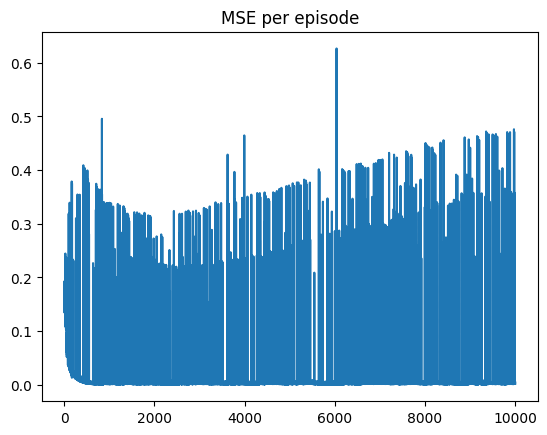

In [15]:
plt.plot(mse_per_episode)
plt.title("MSE per episode")
plt.show()

In [16]:
# obtain predicted values
V = {}
states = grid.all_states()
for s in states:
    if s in grid.actions:
        V[s] = model.predict(s)
    else:
        # terminal state or state we can't otherwise get to
        V[s] = 0

print("values:")
print_values(V, grid)
print("policy:")
print_policy(greedy_policy, grid)


values:
---------------------------
 0.76| 0.84| 0.94| 0.00|
---------------------------
 0.66| 0.00|-0.81| 0.00|
---------------------------
 0.54|-0.71|-0.91|-0.90|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


# approx control

In [53]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D' 'L', 'R')
ACTION2INT = {a: i for i, a in enumerate(ALL_POSSIBLE_ACTIONS)}
INT2ONEHOT = np.eye(len(ALL_POSSIBLE_ACTIONS))

In [54]:
def epsilon_greedy(model, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    values = model.predict_all_actions(s)
    return ALL_POSSIBLE_ACTIONS[np.argmax(values)]
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [55]:
def one_hot(k):
  return INT2ONEHOT[k]

# feature vector is one hot encoding of action, and state (x, y)
def merge_state_action(s, a):
  ai = one_hot(ACTION2INT[a])
  return np.concatenate((s, ai))


def gather_samples(grid, n_episodes=1000):
  samples = []
  for _ in range(n_episodes):
    s = grid.reset()
    while not grid.game_over():
      a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      sa = merge_state_action(s, a)
      samples.append(sa)

      r = grid.move(a)
      s = grid.current_state()
  return samples

In [56]:
class Model:
  def __init__(self, grid):
    # fit the featurizer to data
    samples = gather_samples(grid)
    # self.featurizer = Nystroem()
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s, a):
    sa = merge_state_action(s, a)
    x = self.featurizer.transform([sa])[0]
    return x @ self.w

  def predict_all_actions(self, s):
    return [self.predict(s, a) for a in ALL_POSSIBLE_ACTIONS]

  def grad(self, s, a):
    sa = merge_state_action(s, a)
    x = self.featurizer.transform([sa])[0]
    return x

In [57]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
# grid = standard_grid()
grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [58]:
model = Model(grid)
reward_per_episode = []
state_visit_count = {}

In [59]:
# repeat until convergence
n_episodes = 20000
for it in range(n_episodes):
    if (it + 1) % 1000 == 0:
        print(it + 1)

    s = grid.reset()
    state_visit_count[s] = state_visit_count.get(s, 0) + 1
    episode_reward = 0
    while not grid.game_over():
        a = epsilon_greedy(model, s)
        r = grid.move(a)
        s2 = grid.current_state()
        state_visit_count[s2] = state_visit_count.get(s2, 0) + 1

        # get the target
        if grid.game_over():
            target = r
        else:
            values = model.predict_all_actions(s2)
            target = r + GAMMA * np.max(values)

        # update the model
        g = model.grad(s, a)
        err = target - model.predict(s, a)
        if (it + 1) % 2500 == 0 and episode_reward == 0:
                print("target: ", target)
                print("g: ", g)
                print("model.w: ", model.w)
                print("err: ", err)
                print("\n\n=========================================\n")
        model.w += ALPHA * err * g

        # accumulate reward
        episode_reward += r

        # update state
        s = s2

    reward_per_episode.append(episode_reward)

1000
2000
target:  0.31187561988909307
g:  [ 0.13070824  0.00144823  0.06285821 -0.0700418  -0.09325589 -0.01386834
  0.05793542 -0.13512709 -0.0781552   0.13896391  0.05120411  0.08480144
 -0.11824073 -0.14097259  0.13925672 -0.05821036 -0.06820925  0.13194171
  0.07279686 -0.03466511 -0.12222211 -0.05836728 -0.14120965 -0.13364241
 -0.13745082  0.11080664  0.05286296  0.10983257  0.05411255  0.13311854
 -0.07444479 -0.11975242 -0.12076524 -0.13050598 -0.04998836 -0.10156925
 -0.04029598 -0.0824885  -0.07026307 -0.0428988   0.0255745   0.12514817
 -0.06731274 -0.13986473 -0.11988565 -0.047936   -0.1019486   0.0295481
 -0.03673441  0.14081586  0.13976044  0.04630216 -0.08019368  0.13848232
  0.0258494   0.13006495 -0.07787328 -0.12284239 -0.0394136  -0.04655522
 -0.08089635  0.13063938  0.10189828 -0.04434616 -0.11132399 -0.14083237
 -0.0981264  -0.06885789  0.10706011 -0.01436772 -0.13586129 -0.14007566
  0.08128083 -0.13217775 -0.07478957  0.04697343  0.11424167  0.13891765
 -0.05717

11000
12000
target:  0.31212348992269623
g:  [ 0.13070824  0.00144823  0.06285821 -0.0700418  -0.09325589 -0.01386834
  0.05793542 -0.13512709 -0.0781552   0.13896391  0.05120411  0.08480144
 -0.11824073 -0.14097259  0.13925672 -0.05821036 -0.06820925  0.13194171
  0.07279686 -0.03466511 -0.12222211 -0.05836728 -0.14120965 -0.13364241
 -0.13745082  0.11080664  0.05286296  0.10983257  0.05411255  0.13311854
 -0.07444479 -0.11975242 -0.12076524 -0.13050598 -0.04998836 -0.10156925
 -0.04029598 -0.0824885  -0.07026307 -0.0428988   0.0255745   0.12514817
 -0.06731274 -0.13986473 -0.11988565 -0.047936   -0.1019486   0.0295481
 -0.03673441  0.14081586  0.13976044  0.04630216 -0.08019368  0.13848232
  0.0258494   0.13006495 -0.07787328 -0.12284239 -0.0394136  -0.04655522
 -0.08089635  0.13063938  0.10189828 -0.04434616 -0.11132399 -0.14083237
 -0.0981264  -0.06885789  0.10706011 -0.01436772 -0.13586129 -0.14007566
  0.08128083 -0.13217775 -0.07478957  0.04697343  0.11424167  0.13891765
 -0.057

18000
19000
20000
target:  0.3122138243368108
g:  [ 0.13070824  0.00144823  0.06285821 -0.0700418  -0.09325589 -0.01386834
  0.05793542 -0.13512709 -0.0781552   0.13896391  0.05120411  0.08480144
 -0.11824073 -0.14097259  0.13925672 -0.05821036 -0.06820925  0.13194171
  0.07279686 -0.03466511 -0.12222211 -0.05836728 -0.14120965 -0.13364241
 -0.13745082  0.11080664  0.05286296  0.10983257  0.05411255  0.13311854
 -0.07444479 -0.11975242 -0.12076524 -0.13050598 -0.04998836 -0.10156925
 -0.04029598 -0.0824885  -0.07026307 -0.0428988   0.0255745   0.12514817
 -0.06731274 -0.13986473 -0.11988565 -0.047936   -0.1019486   0.0295481
 -0.03673441  0.14081586  0.13976044  0.04630216 -0.08019368  0.13848232
  0.0258494   0.13006495 -0.07787328 -0.12284239 -0.0394136  -0.04655522
 -0.08089635  0.13063938  0.10189828 -0.04434616 -0.11132399 -0.14083237
 -0.0981264  -0.06885789  0.10706011 -0.01436772 -0.13586129 -0.14007566
  0.08128083 -0.13217775 -0.07478957  0.04697343  0.11424167  0.13891765
 -

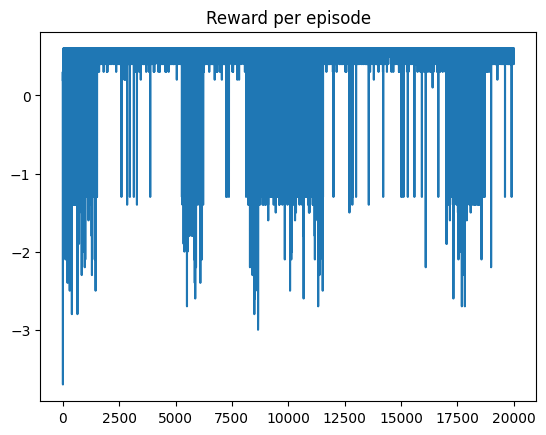

In [60]:
plt.plot(reward_per_episode)
plt.title("Reward per episode")
plt.show()

In [61]:
# obtain V* and pi*
V = {}
greedy_policy = {}
states = grid.all_states()
for s in states:
    if s in grid.actions:
        values = model.predict_all_actions(s)
        V[s] = np.max(values)
        greedy_policy[s] = ALL_POSSIBLE_ACTIONS[np.argmax(values)]
    else:
        # terminal state or state we can't otherwise get to
        V[s] = 0

In [62]:
print("values:")
print_values(V, grid)
print("policy:")
print_policy(greedy_policy, grid)

values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62|-0.99|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  DL  |


In [63]:
  print("state_visit_count:")
  state_sample_count_arr = np.zeros((grid.rows, grid.cols))
  for i in range(grid.rows):
    for j in range(grid.cols):
      if (i, j) in state_visit_count:
        state_sample_count_arr[i, j] = state_visit_count[(i, j)]
  df = pd.DataFrame(state_sample_count_arr)
  print(df)

state_visit_count:
         0        1        2        3
0  13195.0  13126.0  20907.0  19476.0
1  13155.0      0.0   7736.0    524.0
2  20701.0   8384.0   7988.0   1109.0
